In [283]:
import numpy as np
import h5py
import matplotlib.pyplot as plt
import scipy
from PIL import Image
from scipy import ndimage
from dnn_app_utils_v3 import *

%matplotlib inline
plt.rcParams['figure.figsize'] = (5.0, 4.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

%load_ext autoreload
%autoreload 2

np.random.seed(1)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [284]:
train_x_orig, train_y, test_x_orig, test_y, classes = load_data()

y = 0. It's a non-cat picture.


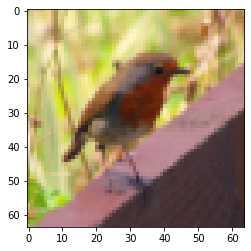

In [285]:
# Example of a picture
index = 10
plt.imshow(train_x_orig[index])
print ("y = " + str(train_y[0,index]) + ". It's a " + classes[train_y[0,index]].decode("utf-8") +  " picture.")

In [286]:
# Explore your dataset 
m_train = train_x_orig.shape[0]
num_px = train_x_orig.shape[1]
m_test = test_x_orig.shape[0]

print ("Number of training examples: " + str(m_train))
print ("Number of testing examples: " + str(m_test))
print ("Each image is of size: (" + str(num_px) + ", " + str(num_px) + ", 3)")
print ("train_x_orig shape: " + str(train_x_orig.shape))
print ("train_y shape: " + str(train_y.shape))
print ("test_x_orig shape: " + str(test_x_orig.shape))
print ("test_y shape: " + str(test_y.shape))

Number of training examples: 209
Number of testing examples: 50
Each image is of size: (64, 64, 3)
train_x_orig shape: (209, 64, 64, 3)
train_y shape: (1, 209)
test_x_orig shape: (50, 64, 64, 3)
test_y shape: (1, 50)


In [287]:
# Reshape the training and test examples 
train_x_flatten = train_x_orig.reshape(train_x_orig.shape[0], -1).T   # The "-1" makes reshape flatten the remaining dimensions
test_x_flatten = test_x_orig.reshape(test_x_orig.shape[0], -1).T

# Standardize data to have feature values between 0 and 1.
train_x = train_x_flatten/255.
test_x = test_x_flatten/255.

print ("train_x's shape: " + str(train_x.shape))
print ("test_x's shape: " + str(test_x.shape))

train_x's shape: (12288, 209)
test_x's shape: (12288, 50)


In [288]:
# GRADED FUNCTION: initialize_parameters_deep

def initialize_parameters_deep(layer_dims):
    """
    Arguments:
    layer_dims -- python array (list) containing the dimensions of each layer in our network
    
    Returns:
    parameters -- python dictionary containing your parameters "W1", "b1", ..., "WL", "bL":
                    Wl -- weight matrix of shape (layer_dims[l], layer_dims[l-1])
                    bl -- bias vector of shape (layer_dims[l], 1)
    """
    
    np.random.seed(3)
    parameters = {}
    L = len(layer_dims)            # number of layers in the network

    for l in range(1, L):
        ### START CODE HERE ### (≈ 2 lines of code)
        parameters['W' + str(l)] = np.random.randn(layer_dims[l], layer_dims[l-1]) * 0.01
        parameters['b' + str(l)] = np.zeros((layer_dims[l], 1))
        ### END CODE HERE ###
        
        assert(parameters['W' + str(l)].shape == (layer_dims[l], layer_dims[l-1]))
        assert(parameters['b' + str(l)].shape == (layer_dims[l], 1))

        
    return parameters

In [289]:
layers_dims = [12288, 20, 7, 5, 1]
parameters = initialize_parameters_deep(layers_dims)
print(parameters.keys())

print(parameters['W1'].shape)
print(parameters['W2'].shape)
print(parameters['W3'].shape)
print(parameters['W4'].shape)

print("\n")

print(parameters['b1'].shape)
print(parameters['b2'].shape)
print(parameters['b3'].shape)
print(parameters['b4'].shape)
print(len(parameters)//2)



dict_keys(['W1', 'b1', 'W2', 'b2', 'W3', 'b3', 'W4', 'b4'])
(20, 12288)
(7, 20)
(5, 7)
(1, 5)


(20, 1)
(7, 1)
(5, 1)
(1, 1)
4


In [290]:
def forward_propagation(X, parameters):
    
    L = len(parameters)//2
    cache = {}
    
    A_prev = X
    
    for l in range(1, L):
        W = parameters['W' + str(l)]
        b = parameters['b' + str(l)]
        
        Z = np.dot(W,A_prev)+b
        A_prev = np.maximum(0,Z)  #RELU function
        
        cache['Z' + str(l)] = Z
        cache['A' + str(l)] = A_prev
        
     
    W = parameters['W' + str(L)]
    b = parameters['b' + str(L)]
    Z = np.dot(W,A_prev)+b
    AL = 1/(1+np.exp(-Z))  #Sigmoid function
     
    cache['Z' + str(L)] = Z
    cache['A' + str(L)] = AL
        
    return AL, cache

In [291]:
# GRADED FUNCTION: compute_cost

def compute_cost(AL, Y):
    """

    Arguments:
    AL -- probability vector corresponding to your label predictions, shape (1, number of examples)
    Y -- true "label" vector (for example: containing 0 if non-cat, 1 if cat), shape (1, number of examples)

    Returns:
    cost -- cross-entropy cost
    """
    
    m = Y.shape[1]

    J = np.multiply(np.log(AL),Y)+np.multiply(np.log(1-AL),(1-Y))
    cost = -(1/m)*np.sum(J)
    
    cost = np.squeeze(cost)      # To make sure your cost's shape is what we expect (e.g. this turns [[17]] into 17).
    assert(cost.shape == ())
    
    return cost

In [292]:
def backward_propagation(parameters, AL, cache, X, Y):
    
    m = X.shape[1]
    
    L = len(parameters)//2
    grads = {}   
    cache['A' + str(0)] = X
    
    
    dZ = AL-Y
    A_prev = cache['A' + str(L-1)]
    dW = (1/m)*np.dot(dZ,A_prev.T)
    db = (1/m)*np.sum(dZ,axis=1,keepdims=True)
    
    grads["dW"+str(L)] = dW
    grads["db"+str(L)] = db
    grads["dZ"+str(L)] = dZ
    
       
    for l in range(L-1,0,-1): # from reverse
        
        A = cache['A' + str(l)]      
        W = parameters['W' + str(l+1)]
        dZ_next = grads["dZ"+str(l+1)]
        A_prev = cache['A' + str(l-1)]
        
        temp = np.zeros(A.shape)
        temp[A < 0] = 0
        temp[A >= 0] = 1
        
        
        dZ = np.dot(W.T,dZ_next)*temp
        dW = (1/m)*np.dot(dZ,A_prev.T)
        db = (1/m)*np.sum(dZ,axis=1,keepdims=True)
        
        grads["dW"+str(l)] = dW
        grads["db"+str(l)] = db
        grads["dZ"+str(l)] = dZ
    
    
    return grads

In [293]:
def update_parameters(parameters, grads, learning_rate):
    """
    Arguments:
    parameters -- python dictionary containing your parameters 
    grads -- python dictionary containing your gradients
    
    Returns:
    parameters -- python dictionary containing your updated parameters 
                  parameters["W" + str(l)] = ... 
                  parameters["b" + str(l)] = ...
    """
    
    L = len(parameters) // 2 # number of layers in the neural network
    
    for l in range(L):
        parameters["W" + str(l+1)] = parameters["W"+str(l+1)]-(learning_rate*grads["dW" + str(l+1)])
        parameters["b" + str(l+1)] = parameters["b"+str(l+1)]-(learning_rate*grads["db" + str(l+1)])
    
    return parameters

In [294]:
def predict(X, y, parameters):
    """
    This function is used to predict the results of a  L-layer neural network.
    
    Arguments:
    X -- data set of examples you would like to label
    parameters -- parameters of the trained model
    
    Returns:
    p -- predictions for the given dataset X
    """
    
    m = X.shape[1]
    n = len(parameters) // 2
    p = np.zeros((1,m))
    
    # Forward propagation
    probas, caches = forward_propagation(X, parameters)

    
    # convert probas to 0/1 predictions
    for i in range(0, probas.shape[1]):
        if probas[0,i] > 0.5:
            p[0,i] = 1
        else:
            p[0,i] = 0
    
    #print results
    #print ("predictions: " + str(p))
    #print ("true labels: " + str(y))
    print("Accuracy: "  + str(np.sum((p == y)/m)))
        
    return p

In [295]:
### CONSTANTS DEFINING THE MODEL ####

layers_dims = [12288, 20, 7, 5, 1]

In [296]:
# GRADED FUNCTION: L_layer_model

def L_layer_model(X, Y, layers_dims, learning_rate = 0.0075, num_iterations = 3000, print_cost=False):
    """
    
    Arguments:
    X -- data, numpy array of shape (num_px * num_px * 3, number of examples)
    Y -- true "label" vector (containing 0 if cat, 1 if non-cat), of shape (1, number of examples)
    layers_dims -- list containing the input size and each layer size, of length (number of layers + 1).
    learning_rate -- learning rate of the gradient descent update rule
    num_iterations -- number of iterations of the optimization loop
    print_cost -- if True, it prints the cost every 100 steps
    
    Returns:
    parameters -- parameters learnt by the model. They can then be used to predict.
    """

    np.random.seed(1)
    costs = []                         # keep track of cost
    
    
    parameters = initialize_parameters_deep(layers_dims)
    
    # Loop (gradient descent)
    for i in range(0, num_iterations):

        # Forward propagation: [LINEAR -> RELU]*(L-1) -> LINEAR -> SIGMOID.        
        AL, cache = forward_propagation(X, parameters)   # AL_Shape: (1, 209) # Z1: (20, 209), Z2: (7, 209), Z3: (5, 209), Z4: (1, 209)
                                                         # A1: (20, 209), A2: (7, 209), A3: (5, 209), A4: (1, 209)
        
        # Compute cost.        
        cost = compute_cost(AL, Y)       
    
        # Backward propagation.        
        grads = backward_propagation(parameters, AL, cache, X, Y)
 
        # Update parameters.
        parameters = update_parameters(parameters, grads, learning_rate)
        
        
        # Print the cost every 100 training example
        if print_cost and i % 100 == 0:
            print ("Cost after iteration %i: %f" %(i, cost))
        if print_cost and i % 100 == 0:
            costs.append(cost)
        
        
    # plot the cost
    plt.plot(np.squeeze(costs))
    plt.ylabel('cost')
    plt.xlabel('iterations (per hundreds)')
    plt.title("Learning rate =" + str(learning_rate))
    plt.show()
    
    return parameters

In [297]:
print(train_x.shape)
print(train_y.shape)

(12288, 209)
(1, 209)


Cost after iteration 0: 0.693148
Cost after iteration 100: 0.678011
Cost after iteration 200: 0.667600
Cost after iteration 300: 0.660422
Cost after iteration 400: 0.655458
Cost after iteration 500: 0.652013
Cost after iteration 600: 0.649616
Cost after iteration 700: 0.647942
Cost after iteration 800: 0.646770
Cost after iteration 900: 0.645947
Cost after iteration 1000: 0.645368
Cost after iteration 1100: 0.644961
Cost after iteration 1200: 0.644673
Cost after iteration 1300: 0.644469
Cost after iteration 1400: 0.644325
Cost after iteration 1500: 0.644223
Cost after iteration 1600: 0.644151
Cost after iteration 1700: 0.644100
Cost after iteration 1800: 0.644063
Cost after iteration 1900: 0.644037
Cost after iteration 2000: 0.644019
Cost after iteration 2100: 0.644006
Cost after iteration 2200: 0.643997
Cost after iteration 2300: 0.643990
Cost after iteration 2400: 0.643985


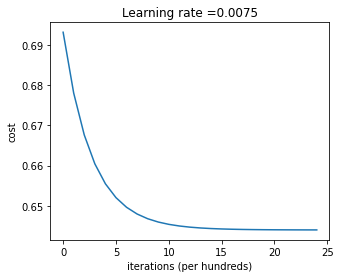

In [298]:
parameters = L_layer_model(train_x, train_y, layers_dims, num_iterations = 2500, print_cost = True)

In [299]:
pred_train = predict(train_x, train_y, parameters)

Accuracy: 0.6555023923444976


In [300]:
pred_test = predict(test_x, test_y, parameters)

Accuracy: 0.3400000000000001
